In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from scipy import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from collections import Counter

In [13]:
df=pd.read_csv('/content/travel_insurance.csv',sep=',')
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [14]:
df.shape

(63326, 11)

In [ ]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Gender', 'Age'],
      dtype='object')

In [15]:
for i in df.columns:
  if(df[i].is_unique):
    df=df.drop(i,axis=1)
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [ ]:
df.shape

(63326, 11)

In [ ]:
df.dtypes

Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Claim                    object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Gender                   object
Age                       int64
dtype: object

In [ ]:
for i in df.columns:
  print('length of '+str(i)+' =',len(df[i].unique()))

length of Agency = 16
length of Agency Type = 2
length of Distribution Channel = 2
length of Product Name = 26
length of Claim = 2
length of Duration = 455
length of Destination = 149
length of Net Sales = 1139
length of Commision (in value) = 1035
length of Gender = 3
length of Age = 89


In [16]:
print('Categorical Columns are:')
cat_cols=[]
for i in df.columns:
  if((len(df[i].unique()))<int(df.shape[0]/130)):
    cat_cols.append(i)
print(cat_cols)

Categorical Columns are:
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Claim', 'Duration', 'Destination', 'Gender', 'Age']


In [17]:
cont_cols=list(set(df.columns) - set(cat_cols))
cont_cols

['Net Sales', 'Commision (in value)']

In [18]:
m=df['Duration'].mean()
df.loc[df['Duration'] <= 0, 'Duration'] = int(m)

Handling Outliers

In [19]:
#Checking Skewness
for i in cont_cols:
  print(str(i)+' : '+str(df[i].skew()))

Net Sales : 3.272372822599944
Commision (in value) : 4.032268514691959


In [20]:
#Outlier handling by quantile capping and flooring at 10% and 90%
for i in cont_cols:
  lower=df[i].quantile(0.10)
  upper=df[i].quantile(0.90)
  df[i]=np.where(df[i]<lower,lower,df[i])
  df[i]=np.where(df[i]>upper,upper,df[i])
  print('After Handling outlier, skewness of '+str(i)+' is: ',str(df[i].skew()))

After Handling outlier, skewness of Net Sales is:  0.8913342339002208
After Handling outlier, skewness of Commision (in value) is:  1.2859578179216349


Handling Missing Values

In [21]:
#Number of Missing Values in each feature
df.isnull().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  45107
Age                         0
dtype: int64

In [22]:
df['Gender'].fillna('X',inplace=True)
df.isnull().sum()

Deriving Correlation patterns of each independent varaible with the target/dependent variable(Claim)

In [24]:
le=LabelEncoder()
target_df=pd.DataFrame()
target_df['Claim']=le.fit_transform(df['Claim'])
target_df.head()

,Claim
0,0
1,0
2,0
3,0
4,0


In [25]:
print(df['Claim'].value_counts())
lbl_1,lbl_0 = target_df['Claim'].value_counts()
print("Label 0 class %age: "+str((lbl_1*100)/target_df['Claim'].count()))
print("Label 1 class %age: "+str((lbl_0*100)/target_df['Claim'].count()))

No     62399
Yes      927
Name: Claim, dtype: int64
Label 0 class %age: 98.53614629062312
Label 1 class %age: 1.4638537093768753


In [26]:
df=df.drop(columns='Claim')
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Gender', 'Age'],
      dtype='object')

Label Encoding

In [27]:
df_le=df.copy()
df_le.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,186,MALAYSIA,10.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,186,MALAYSIA,10.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,65,AUSTRALIA,10.0,29.70,X,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,60,AUSTRALIA,10.0,23.76,X,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,79,ITALY,10.0,11.88,X,41


In [28]:
cat_cols=list(set(cat_cols)-set(['Claim','Duration','Age']))
for i in cat_cols:
  df_le['enc_'+str(i)]=le.fit_transform(df_le[i])
df_enc_le = df_le.drop(columns = cat_cols)
df_enc_le.columns


Index(['Duration', 'Net Sales', 'Commision (in value)', 'Age', 'enc_Agency',
       'enc_Gender', 'enc_Distribution Channel', 'enc_Destination',
       'enc_Product Name', 'enc_Agency Type'],
      dtype='object')

### Imbalance Class handling function

Options of using RandomOverSampling , RandomUnderSampling , SMOTE+TL , ADASYN techniques

In [ ]:
def doImbalanceHandling(x_train, y_train, balance_type):
    """
    search for name of class handling tech in the run name and apply the technique to get the
    transformed train dataset
    :returns: training dataset(x_res, y_res) after handing class imbalance
    :param x_train: training feature set
    :param y_train: training target class
    :return: training feature set and target variable after applying class imbalance handling
    """
    if 'smote_tomek' in balance_type.lower():
        sm = SMOTE(random_state=42, sampling_strategy=0.3, n_jobs=-1)  # ratio={'1':10000, '0':171044}
        x_sm, y_sm = sm.fit_sample(x_train, y_train)
        tl = TomekLinks(random_state=42)
        x_res, y_res = tl.fit_sample(x_sm, y_sm)
    elif 'rus' in balance_type.lower():
        # RandomUnderSampler
        rus = RandomUnderSampler(random_state=42)
        x_res, y_res = rus.fit_sample(x_train, y_train)
    elif 'adasyn' in balance_type.lower():
        # ADASYN
        ada = ADASYN(random_state=42, sampling_strategy=0.3, n_jobs=-1)
        x_res, y_res = ada.fit_sample(x_train, y_train)
    elif 'ros' in balance_type.lower():
        # RANDOMOVERSAMPLER
        ros = RandomOverSampler(random_state=42)
        x_res, y_res = ros.fit_sample(x_train, y_train)
    #print('original dataset shape %s' % Counter(y_train))
    print('Resampled dataset shape %s' % Counter(y_res))
    print('x %s', x_res.shape)
    return x_res, y_res

Splitting the dataset into training and testing data

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df_enc_le, target_df, test_size=0.25, random_state=33 , stratify=target_df)

In [31]:
print('set of training features: ', len(x_train))
print('set of training label: ', len(y_train))
print('set of testing features: ', len(x_test))
print('set of testing label: ', len(y_test))

set of training features:  47494
set of training label:  47494
set of testing features:  15832
set of testing label:  15832


In [32]:
print('For Training')
print(y_train['Claim'].value_counts())
l1,l2=y_train['Claim'].value_counts()
print("Label 0 percentage: "+str((l1*100)/y_train['Claim'].count()))
print("Label 1 percentage: "+str((l2*100)/y_train['Claim'].count()))

print('\n For Testing')
print(y_test['Claim'].value_counts())
l1,l2=y_test['Claim'].value_counts()
print("Label 0 percentage: "+str((l1*100)/y_test['Claim'].count()))
print("Label 1 percentage: "+str((l2*100)/y_test['Claim'].count()))

For Training
0    46799
1      695
Name: Claim, dtype: int64
Label 0 percentage: 98.53665726196994
Label 1 percentage: 1.463342738030067

 For Testing
0    15600
1      232
Name: Claim, dtype: int64
Label 0 percentage: 98.53461344113188
Label 1 percentage: 1.4653865588681152


### Applying PCA & Scaling the values for plotting

In [38]:
pca.explained_variance_ratio_

array([0.80317985, 0.13297634, 0.03930765, 0.01568597, 0.00669863])

In [41]:
pca = PCA(n_components=1)
dim = pca.fit_transform(x_train)
dim

array([[-22.54230261],
       [215.54305146],
       [ 32.18225722],
       ...,
       [-48.69045336],
       [-36.8690753 ],
       [-20.58094457]])

In [42]:
scaler = MinMaxScaler()
res =scaler.fit_transform(dim)
res

array([[0.00625048],
       [0.05546988],
       [0.01756369],
       ...,
       [0.00084487],
       [0.00328871],
       [0.00665595]])

In [45]:
pca = PCA(n_components=1)
dim = pca.fit_transform(x_train)
print(pca.explained_variance_ratio_)
scaler = MinMaxScaler()
res =scaler.fit_transform(dim)
dummy = pd.DataFrame(res,columns=['component'])
y_tmp=y_train.copy()
y_tmp = y_tmp.reset_index()
dummy['label'] = y_tmp['Claim']
dummy.head()

[0.80317985]


,component,label
0,0.006250,0
1,0.055470,0
2,0.017564,0
3,0.005494,0
4,0.031012,0


In [46]:
dummy.shape

(47494, 2)

In [47]:
dum_sample = dummy.sample(frac = 0.10 ,random_state= 42)
dum_sample = dum_sample[dum_sample['component'] < 0.90]

In [ ]:
print(dum_sample['label'].value_counts())
l1,l2=dum_sample['label'].value_counts()
print("Label 0 percentage: "+str((l1*100)/dum_sample['label'].count()))
print("Label 1 percentage: "+str((l2*100)/dum_sample['label'].count()))

0    4672
1      76
Name: label, dtype: int64
Label 0 percentage: 98.39932603201348
Label 1 percentage: 1.6006739679865207


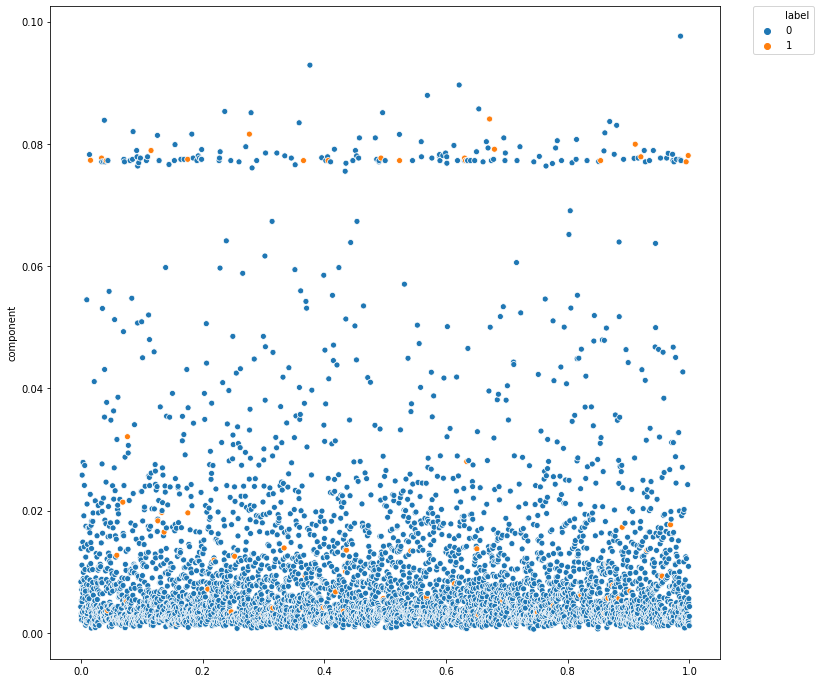

In [ ]:
#Showcasing the data in a scatter plot
x_val = np.linspace(0, 1, len(dum_sample))
plt.figure(figsize=(12, 12))
sns.scatterplot(x= x_val , y='component', hue='label', data =dum_sample)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**RandomOverSampling**

In [ ]:
x_train_ros, y_train_ros = doImbalanceHandling(x_train, y_train.values.ravel(), 'ros')

Resampled dataset shape Counter({0: 46799, 1: 46799})
x %s (93598, 10)


In [ ]:
#After imbalance handling
pca = PCA(n_components=1)
dim = pca.fit_transform(x_train_ros)
print(pca.explained_variance_ratio_)
scaler = MinMaxScaler()
res =scaler.fit_transform(dim)
dummy = pd.DataFrame(res,columns=['component'])
y_tmp=y_train_ros.copy()
dummy['label'] = y_tmp
dum_sample = dummy.sample(frac = 0.10 ,random_state= 42)
dum_sample = dum_sample[dum_sample['component'] < 0.90]
#dum_sample = dum_sample[dum_sample['component'] < 0.80]
print(dum_sample['label'].value_counts())
l1,l2=dum_sample['label'].value_counts()
print("Label 0 percentage: "+str((l1*100)/dum_sample['label'].count()))
print("Label 1 percentage: "+str((l2*100)/dum_sample['label'].count()))

[0.87525248]
0    4766
1    4593
Name: label, dtype: int64
Label 0 percentage: 50.92424404316701
Label 1 percentage: 49.07575595683299


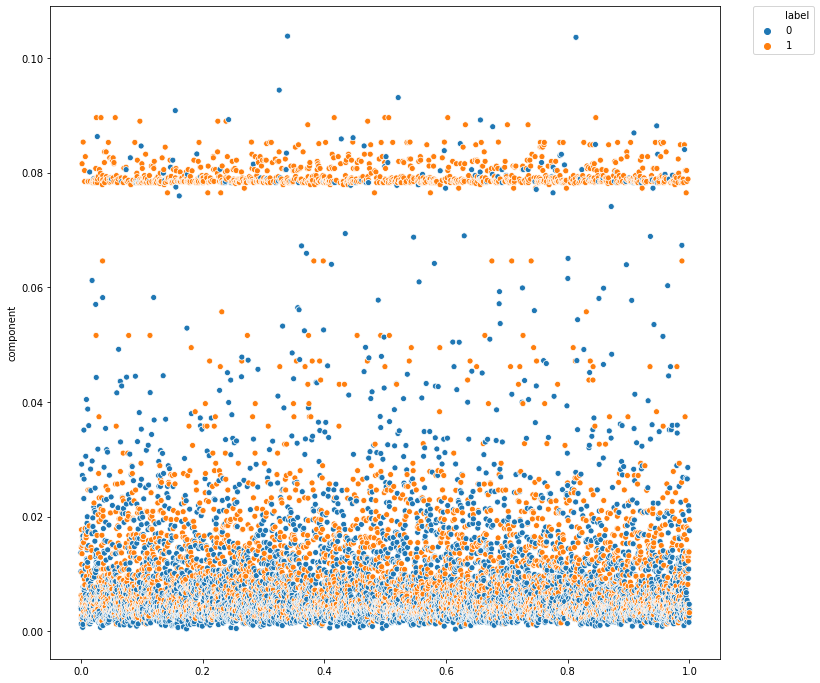

In [ ]:
#Showcasing the data in a scatter plot
x_val = np.linspace(0, 1, len(dum_sample))
plt.figure(figsize=(12, 12))
sns.scatterplot(x= x_val , y='component', hue='label', data =dum_sample)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**RandomUnderSampling**

In [ ]:
x_train_rus, y_train_rus = doImbalanceHandling(x_train, y_train.values.ravel(), 'rus')

Resampled dataset shape Counter({0: 695, 1: 695})
x %s (1390, 10)


In [ ]:
#After imbalance handling
pca = PCA(n_components=1)
dim = pca.fit_transform(x_train_rus)
print(pca.explained_variance_ratio_)
scaler = MinMaxScaler()
res =scaler.fit_transform(dim)
dummy = pd.DataFrame(res,columns=['component'])
y_tmp=y_train_rus.copy()
dummy['label'] = y_tmp
dum_sample = dummy.sample(frac = 0.10 ,random_state= 42)
dum_sample = dum_sample[dum_sample['component'] < 0.90]
#dum_sample = dum_sample[dum_sample['component'] < 0.80]
print(dum_sample['label'].value_counts())
l1,l2=dum_sample['label'].value_counts()
print("Label 0 percentage: "+str((l1*100)/dum_sample['label'].count()))
print("Label 1 percentage: "+str((l2*100)/dum_sample['label'].count()))

[0.8619736]
0    76
1    60
Name: label, dtype: int64
Label 0 percentage: 55.88235294117647
Label 1 percentage: 44.11764705882353


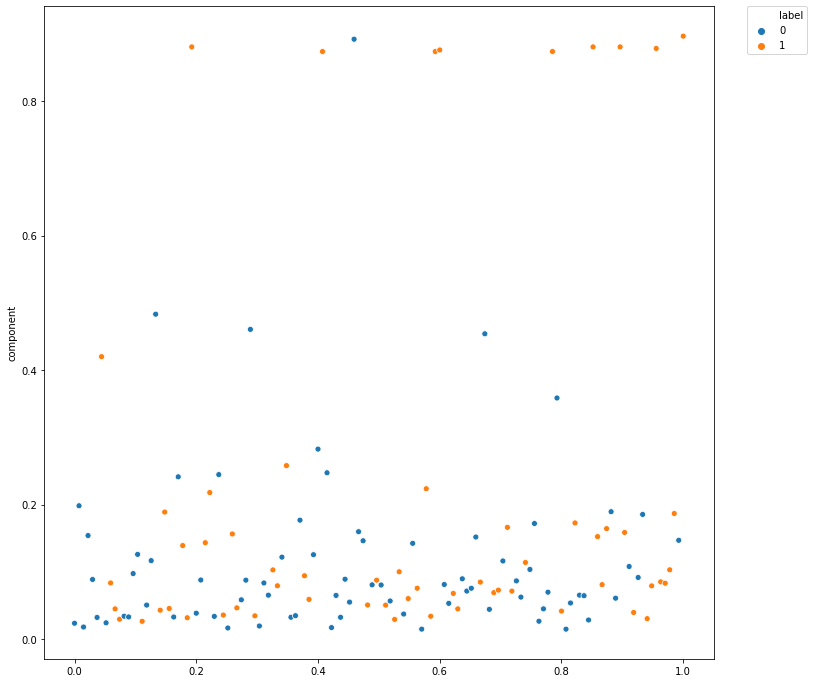

In [ ]:
#Showcasing the data in a scatter plot
x_val = np.linspace(0, 1, len(dum_sample))
plt.figure(figsize=(12, 12))
sns.scatterplot(x= x_val , y='component', hue='label', data =dum_sample)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Smote+TomekLinks**

In [ ]:
x_train_sm, y_train_sm = doImbalanceHandling(x_train, y_train.values.ravel(), 'smote_tomek')

Resampled dataset shape Counter({0: 46441, 1: 14039})
x %s (60480, 10)


In [ ]:
#After imbalance handling
pca = PCA(n_components=1)
dim = pca.fit_transform(x_train_sm)
print(pca.explained_variance_ratio_)
scaler = MinMaxScaler()
res =scaler.fit_transform(dim)
dummy = pd.DataFrame(res,columns=['component'])
y_tmp=y_train_sm.copy()
dummy['label'] = y_tmp
dum_sample = dummy.sample(frac = 0.10 ,random_state= 42)
#dum_sample = dum_sample[dum_sample['component'] < 0.90]
#dum_sample = dum_sample[dum_sample['component'] < 0.80]
print(dum_sample['label'].value_counts())
l1,l2=dum_sample['label'].value_counts()
print("Label 0 percentage: "+str((l1*100)/dum_sample['label'].count()))
print("Label 1 percentage: "+str((l2*100)/dum_sample['label'].count()))

[0.84300506]
0    4647
1    1401
Name: label, dtype: int64
Label 0 percentage: 76.83531746031746
Label 1 percentage: 23.16468253968254


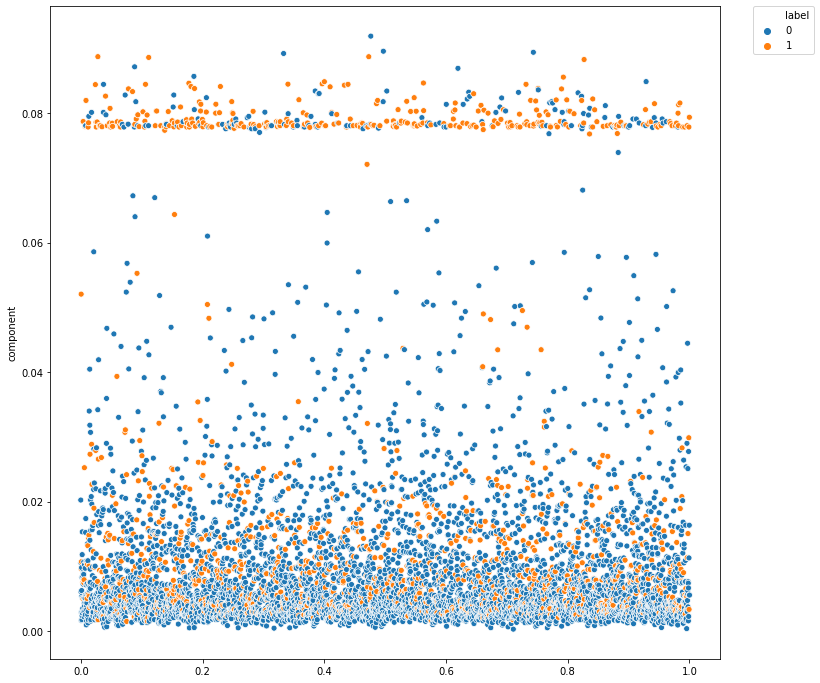

In [ ]:
#Showcasing the data in a scatter plot
x_val = np.linspace(0, 1, len(dum_sample))
plt.figure(figsize=(12, 12))
sns.scatterplot(x= x_val , y='component', hue='label', data =dum_sample)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Adasyn**

In [ ]:
x_train_ads, y_train_ads = doImbalanceHandling(x_train, y_train.values.ravel(), 'adasyn')

Resampled dataset shape Counter({0: 46799, 1: 14231})
x %s (61030, 10)


In [ ]:
#After imbalance handling
pca = PCA(n_components=1)
dim = pca.fit_transform(x_train_ads)
print(pca.explained_variance_ratio_)
scaler = MinMaxScaler()
res =scaler.fit_transform(dim)
dummy = pd.DataFrame(res,columns=['component'])
y_tmp=y_train_ads.copy()
dummy['label'] = y_tmp
dum_sample = dummy.sample(frac = 0.10 ,random_state= 42)
#dum_sample = dum_sample[dum_sample['component'] < 0.90]
#dum_sample = dum_sample[dum_sample['component'] < 0.80]
print(dum_sample['label'].value_counts())
l1,l2=dum_sample['label'].value_counts()
print("Label 0 percentage: "+str((l1*100)/dum_sample['label'].count()))
print("Label 1 percentage: "+str((l2*100)/dum_sample['label'].count()))

[0.83869228]
0    4697
1    1406
Name: label, dtype: int64
Label 0 percentage: 76.96214976241193
Label 1 percentage: 23.03785023758807


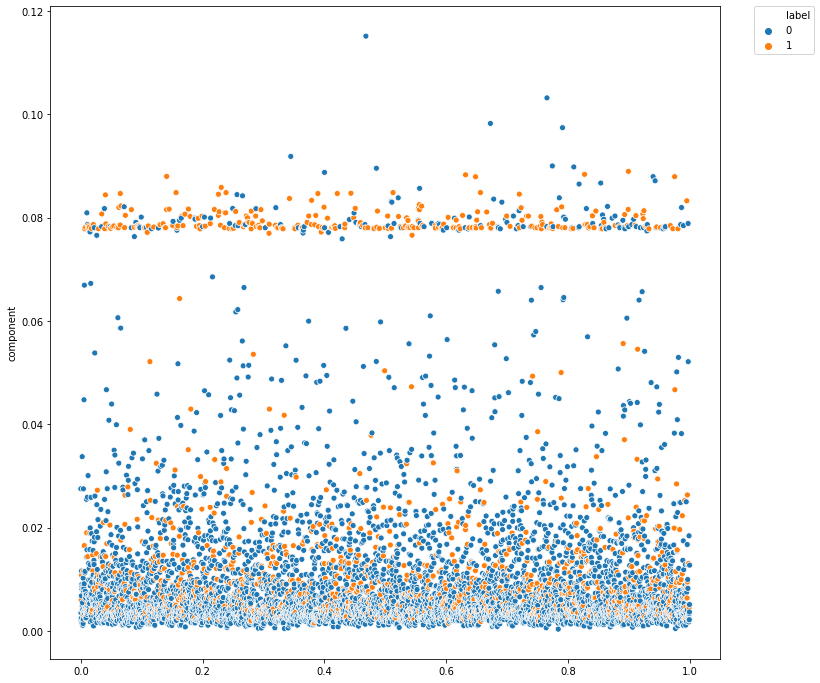

In [ ]:
#Showcasing the data in a scatter plot
x_val = np.linspace(0, 1, len(dum_sample))
plt.figure(figsize=(12, 12))
sns.scatterplot(x= x_val , y='component', hue='label', data =dum_sample)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)